In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants, analysis
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine  = pudl.db_connect_pudl()

In [3]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9 , 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [4]:
g9_summed[g9_summed['plant_id'] == 564]

,plant_id,report_date,generator_id,net_generation_mwh
1636,564,2009,1,3041651.000
1637,564,2009,2,2937124.000
1638,564,2010,1,2627162.000
1639,564,2010,2,3064141.000
1640,564,2010,B,419692.585
1641,564,2011,1,2117660.000
1642,564,2011,2,2567967.000
1643,564,2011,B,399618.023
1644,564,2012,1,1070092.000
1645,564,2012,2,2064954.000


In [5]:
g9_summed[(g9_summed['plant_id'] == 891) & (g9_summed['report_date'] == 2010)]

,plant_id,report_date,generator_id,net_generation_mwh
2968,891,2010,1,0.0
2969,891,2010,2,0.0
2970,891,2010,3,117.0
2971,891,2010,4,102.0
2972,891,2010,5,35.0
2973,891,2010,6,2998816.0


In [6]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = analysis.simple_select('boiler_generator_assn_eia860', pudl_engine)
bga8.drop(['id','operator_id'],axis=1, inplace=True)
bga8.drop_duplicates(['plant_id','boiler_id','generator_id'],inplace=True)

In [7]:
gens8 = bga8.drop_duplicates(subset=['plant_id','generator_id'])

In [8]:
bga8[bga8['plant_id'] == 3]

,plant_id,boiler_id,generator_id
2432,3,1,1
2433,3,2,2
2434,3,3,3
2435,3,4,4
2436,3,5,5
2437,3,6A,A1ST
2438,3,6B,A1ST
2439,3,7A,A2ST
2440,3,7B,A2ST


In [9]:
## Trying to figure out which generators are missing

In [10]:
gens9 = g9_summed.drop_duplicates(subset=['plant_id','generator_id','report_date'])

In [11]:
# get the primary fuel for each plant (to be used to combine plants that have unassociated generators)
gf9 = analysis.simple_select('generation_fuel_eia923', pudl_engine)
primary_fuel9 = analysis.primary_fuel_gf_eia923(gf9).rename(columns={'year':'report_date'})

In [93]:
gens = gens9.merge(gens8, on=['plant_id', 'generator_id'], how="left")
gens.boiler_id = gens.boiler_id.astype(str)

In [94]:
gens['boiler_generator_assn'] = np.where(gens['boiler_id']=='nan', False, True)

In [95]:
gens.count()

plant_id                 27006
report_date              27006
generator_id             27006
net_generation_mwh       27006
boiler_id                27006
boiler_generator_assn    27006
dtype: int64

In [96]:
unassociated_plants = gens[gens['boiler_generator_assn'] == False].\
                      drop_duplicates(subset=['plant_id','report_date']).\
                      drop(['generator_id', 'net_generation_mwh','boiler_id','boiler_generator_assn'],axis=1)

In [97]:
unassociated_plants['plant_assn'] = False

In [98]:
unassociated_plants.head()

,plant_id,report_date,plant_assn
40,3,2014,False
51,3,2015,False
62,3,2016,False
353,96,2014,False
356,96,2015,False


In [99]:
gens = gens.merge(unassociated_plants, on=['plant_id','report_date'],how='left')

In [100]:
gens['plant_assn'] = gens.plant_assn.fillna(value=True)

In [101]:
gens[gens['plant_id'] == 3]

,plant_id,report_date,generator_id,net_generation_mwh,boiler_id,boiler_generator_assn,plant_assn
0,3,2009,1,221908.0,1,True,True
1,3,2009,2,394031.0,2,True,True
2,3,2009,3,1286393.0,3,True,True
3,3,2009,4,1626547.0,4,True,True
4,3,2009,5,4513101.0,5,True,True
5,3,2009,A1ST,1122697.0,6A,True,True
6,3,2009,A2ST,1033733.0,7A,True,True
7,3,2010,1,435334.0,1,True,True
8,3,2010,2,538495.0,2,True,True
9,3,2010,3,906322.0,3,True,True


In [15]:
gens_unassn_plants = unassociated_plants.merge(gens, on=['plant_id','report_date'])

In [16]:
gens_unassn_plants = gens_unassn_plants.merge(primary_fuel9, on=['plant_id','report_date'],)

In [17]:
gup_gb = gens_unassn_plants.groupby(by=['plant_id','report_date'])
gens_unassn_plants_summed = gup_gb.agg({'net_generation_mwh': np.sum})
gens_unassn_plants_summed.reset_index(inplace=True)

In [18]:
gens_unassn_plants_summed.head(30)

,plant_id,report_date,net_generation_mwh
0,3,2014,11445330.00
1,3,2015,11387562.00
2,3,2016,12770891.00
3,96,2014,675265.00
4,96,2015,188818.00
5,117,2014,1430661.00
6,117,2015,1811587.00
7,117,2016,2566810.00
8,147,2014,655706.00
9,147,2015,872866.00


In [19]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_plant_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date'])
bf9_plant_summed.reset_index(inplace=True)

In [20]:
bf9_plant_summed.head()

,plant_id,report_date,fuel_consumed_mmbtu
0,3,2009,8.057854e+07
1,3,2010,7.974024e+07
2,3,2011,4.914123e+07
3,3,2012,5.523643e+07
4,3,2013,5.299733e+07


In [21]:
unassn_plants = gens_unassn_plants_summed.merge(bf9_plant_summed, on=['plant_id','report_date'])
unassn_plants['heat_rate_mmbtu_mwh'] = unassn_plants['fuel_consumed_mmbtu'] / unassn_plants['net_generation_mwh']

In [23]:
unassn_plants

,plant_id,report_date,net_generation_mwh,fuel_consumed_mmbtu,heat_rate_mmbtu_mwh
0,3,2014,11445330.00,9.203481e+07,8.041255
1,3,2015,11387562.00,9.452387e+07,8.300624
2,3,2016,12770891.00,1.027498e+08,8.045623
3,96,2014,675265.00,5.804498e+06,8.595882
4,96,2015,188818.00,1.784501e+06,9.450905
5,117,2014,1430661.00,1.186810e+07,8.295536
6,117,2015,1811587.00,1.590001e+07,8.776843
7,117,2016,2566810.00,2.278821e+07,8.878028
8,147,2014,655706.00,4.771569e+06,7.276995
9,147,2015,872866.00,6.480555e+06,7.424456


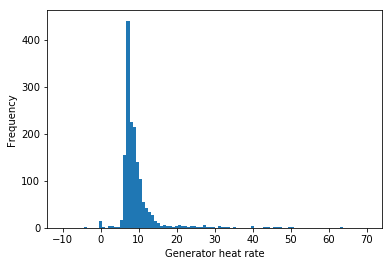

In [22]:
unassn_plants['heat_rate_mmbtu_mwh'].plot(kind='hist', bins=100, range=[-10,70])
plt.xlabel('Generator heat rate')
plt.show()

In [ ]:
unassn_plants[unassn_plants['heat_rate_mmbtu_mwh'] > 100]

In [ ]:
gens_missing = gens[(gens['boiler_id'] == 'nan')]

In [ ]:
gens_missing.drop_duplicates(subset=['prime_mover'])

In [ ]:
gens_missing[gens_missing['prime_mover'] == 'ST'].count()

In [ ]:
gens_missing[gens_missing['prime_mover'] == 'CA'].count()

In [ ]:
gens_missing[gens_missing['prime_mover'] == 'CT'].count()

In [ ]:
gens_missing[gens_missing['prime_mover'] == 'CS'].count()

In [24]:
generation_w_boilers = g9_summed.merge(bga8,how='left',on=['plant_id','generator_id'])

In [25]:
generation_w_boilers[(generation_w_boilers['plant_id'] == 891) & (generation_w_boilers['report_date'] == 2010)]

,plant_id,report_date,generator_id,net_generation_mwh,boiler_id
3411,891,2010,1,0.0,4
3412,891,2010,1,0.0,5
3413,891,2010,1,0.0,6
3414,891,2010,1,0.0,7
3415,891,2010,1,0.0,8
3416,891,2010,1,0.0,1
3417,891,2010,1,0.0,2
3418,891,2010,1,0.0,3
3419,891,2010,2,0.0,4
3420,891,2010,2,0.0,5


In [26]:
gb = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id'])
generation_w_boilers_summed = gb.agg({'net_generation_mwh': np.sum})
generation_w_boilers_summed.reset_index(inplace=True)
generation_w_boilers_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler'}, inplace=True)

In [27]:
generation_w_boilers_summed.head()

,plant_id,report_date,boiler_id,net_generation_mwh_boiler
0,3,2009,1,221908.0
1,3,2009,2,394031.0
2,3,2009,3,1286393.0
3,3,2009,4,1626547.0
4,3,2009,5,4513101.0


In [28]:
gb = generation_w_boilers.groupby(by=['plant_id','report_date','boiler_id','generator_id'])
generation_w_bg_summed = gb.agg({'net_generation_mwh': np.sum})
generation_w_bg_summed.reset_index(inplace=True)
generation_w_bg_summed.rename(columns={'net_generation_mwh':'net_generation_mwh_boiler_gen'}, inplace=True)

In [29]:
generation_w_boilers_summed = generation_w_boilers_summed.merge(generation_w_bg_summed, how='left', on=['plant_id','report_date','boiler_id'])

In [30]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)

In [31]:
bf9_summed[(bf9_summed['plant_id'] == 891) & (bf9_summed['report_date'] == 2010)]

,plant_id,report_date,boiler_id,fuel_consumed_mmbtu
3074,891,2010,1,1.131480e+03
3075,891,2010,2,1.131480e+03
3076,891,2010,3,1.131480e+03
3077,891,2010,4,1.131480e+03
3078,891,2010,5,1.131480e+03
3079,891,2010,6,1.131480e+03
3080,891,2010,7,1.131480e+03
3081,891,2010,8,1.131480e+03
3082,891,2010,9,3.500543e+07


In [32]:
bf9_summed[(bf9_summed['plant_id'] == 79) & (bf9_summed['report_date'] == 2010)]

,plant_id,report_date,boiler_id,fuel_consumed_mmbtu
336,79,2010,1,391923.0
337,79,2010,2,416510.0
338,79,2010,3,439242.0
339,79,2010,5,2103444.0


In [33]:
bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])

In [34]:
bg = bg.merge(generation_w_boilers_summed, how='left', on=['plant_id','report_date', 'boiler_id', 'generator_id'])

In [35]:
bg['proportion_of_gen_by_boil_gen'] = bg['net_generation_mwh_boiler_gen'] / bg['net_generation_mwh_boiler']
bg['fuel_consumed_mmbtu_per_gen'] = bg['proportion_of_gen_by_boil_gen'] * bg['fuel_consumed_mmbtu']

In [36]:
bg[(bg['plant_id'] == 79) & (bg['report_date'] == 2010)].sort_values(['plant_id','boiler_id','generator_id'])

,plant_id,report_date,boiler_id,fuel_consumed_mmbtu,generator_id,net_generation_mwh_boiler,net_generation_mwh_boiler_gen,proportion_of_gen_by_boil_gen,fuel_consumed_mmbtu_per_gen
348,79,2010,1,391923.0,1,204196.0,40302.0,0.197369,7.735353e+04
347,79,2010,1,391923.0,2,204196.0,11121.0,0.054462,2.134506e+04
350,79,2010,1,391923.0,3,NaN,NaN,NaN,NaN
349,79,2010,1,391923.0,5,204196.0,152773.0,0.748168,2.932244e+05
346,79,2010,1,391923.0,7,NaN,NaN,NaN,NaN
352,79,2010,2,416510.0,1,51423.0,40302.0,0.783735,3.264334e+05
353,79,2010,2,416510.0,2,51423.0,11121.0,0.216265,9.007657e+04
354,79,2010,2,416510.0,3,NaN,NaN,NaN,NaN
351,79,2010,2,416510.0,7,NaN,NaN,NaN,NaN
356,79,2010,3,439242.0,1,51423.0,40302.0,0.783735,3.442493e+05


In [37]:
# Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
bg_summed = bg_gb.agg({'fuel_consumed_mmbtu_per_gen':np.sum})
bg_summed.reset_index(inplace=True)

In [38]:
bg_summed[(bg_summed['plant_id'] == 79) & (bg_summed['report_date'] == 2010)]

,plant_id,report_date,generator_id,fuel_consumed_mmbtu_per_gen
309,79,2010,1,7.480362e+05
310,79,2010,2,2.064143e+05
311,79,2010,3,NaN
312,79,2010,5,2.396668e+06
313,79,2010,7,NaN


In [102]:
heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu_per_gen'] / heat_rate['net_generation_mwh']

In [103]:
heat_rate = heat_rate.merge(gens[['plant_id','report_date','generator_id','plant_assn']], on=['plant_id','report_date','generator_id'])

In [106]:
heat_rate = heat_rate[heat_rate['plant_assn'] == True]

In [107]:
heat_rate[heat_rate['plant_id'] == 3]

,plant_id,report_date,generator_id,fuel_consumed_mmbtu_per_gen,net_generation_mwh,heat_rate_mmbtu_mwh,plant_assn
0,3,2009,1,2.282135e+06,221908.0,10.284149,True
1,3,2009,2,4.047126e+06,394031.0,10.271086,True
2,3,2009,3,1.306599e+07,1286393.0,10.157073,True
3,3,2009,4,1.616073e+07,1626547.0,9.935606,True
4,3,2009,5,4.470910e+07,4513101.0,9.906513,True
5,3,2009,A1ST,1.760776e+05,1122697.0,0.156834,True
6,3,2009,A2ST,1.373917e+05,1033733.0,0.132908,True
7,3,2010,1,4.524332e+06,435334.0,10.392783,True
8,3,2010,2,5.721033e+06,538495.0,10.624116,True
9,3,2010,3,9.570256e+06,906322.0,10.559444,True


In [ ]:
heat_rate[(heat_rate['heat_rate_mmbtu_mwh'] < 1) & (heat_rate['heat_rate_mmbtu_mwh'] > 0)]

In [ ]:
# Convert the boiler_fuel_eia923 table into a dataframe
bf9 = analysis.simple_select('boiler_fuel_eia923', pudl_engine)
bf9['fuel_consumed_mmbtu'] = bf9['fuel_qty_consumed']*bf9['fuel_mmbtu_per_unit']
# Get yearly fuel consumed by plant_id, year and boiler_id
bf9_summed = analysis.yearly_sum_eia(bf9 , 'fuel_consumed_mmbtu', columns=['plant_id','report_date','boiler_id'])
bf9_summed.reset_index(inplace=True)

In [ ]:
# Convert the boiler_generator_assn_eia860 table into a dataframe
bga8 = analysis.simple_select('boiler_generator_assn_eia860', pudl_engine)
bga8.drop(['id','operator_id'],axis=1, inplace=True)

In [ ]:
bg = bf9_summed.merge(bga8,how='left',on=['plant_id','boiler_id'])

In [ ]:
# Get yearly fuel_consumed_mmbtu by plant_id, year and generator_id
bg_gb = bg.groupby(by=['plant_id','report_date','generator_id'])
bg_summed = bg_gb.agg({'fuel_consumed_mmbtu':np.sum})
bg_summed.reset_index(inplace=True)

In [ ]:
# Convert the generation_eia923 table into a dataframe
g9 = analysis.simple_select('generation_eia923', pudl_engine)
# Get yearly net generation by plant_id, year and generator_id
g9_summed = analysis.yearly_sum_eia(g9 , 'net_generation_mwh')
g9_summed.reset_index(inplace=True)

In [ ]:
heat_rate = bg_summed.merge(g9_summed,how='left',on=['plant_id', 'report_date', 'generator_id'])
heat_rate['heat_rate_mmbtu_mwh'] = heat_rate['fuel_consumed_mmbtu'] / heat_rate['net_generation_mwh']
heat_rate

In [ ]:
# remove heat_rate_mmbtu_mwh values that are 'inf' and <= 0
heat_rate = heat_rate.replace([np.inf, -np.inf], np.nan).dropna(subset=["heat_rate_mmbtu_mwh"])
heat_rate = heat_rate[heat_rate.heat_rate_mmbtu_mwh > 0]

In [ ]:
heat_rate['heat_rate_mmbtu_mwh'].plot(kind='hist', bins=100, range=[-20,70])
plt.xlabel('Generator heat rate')
plt.show()